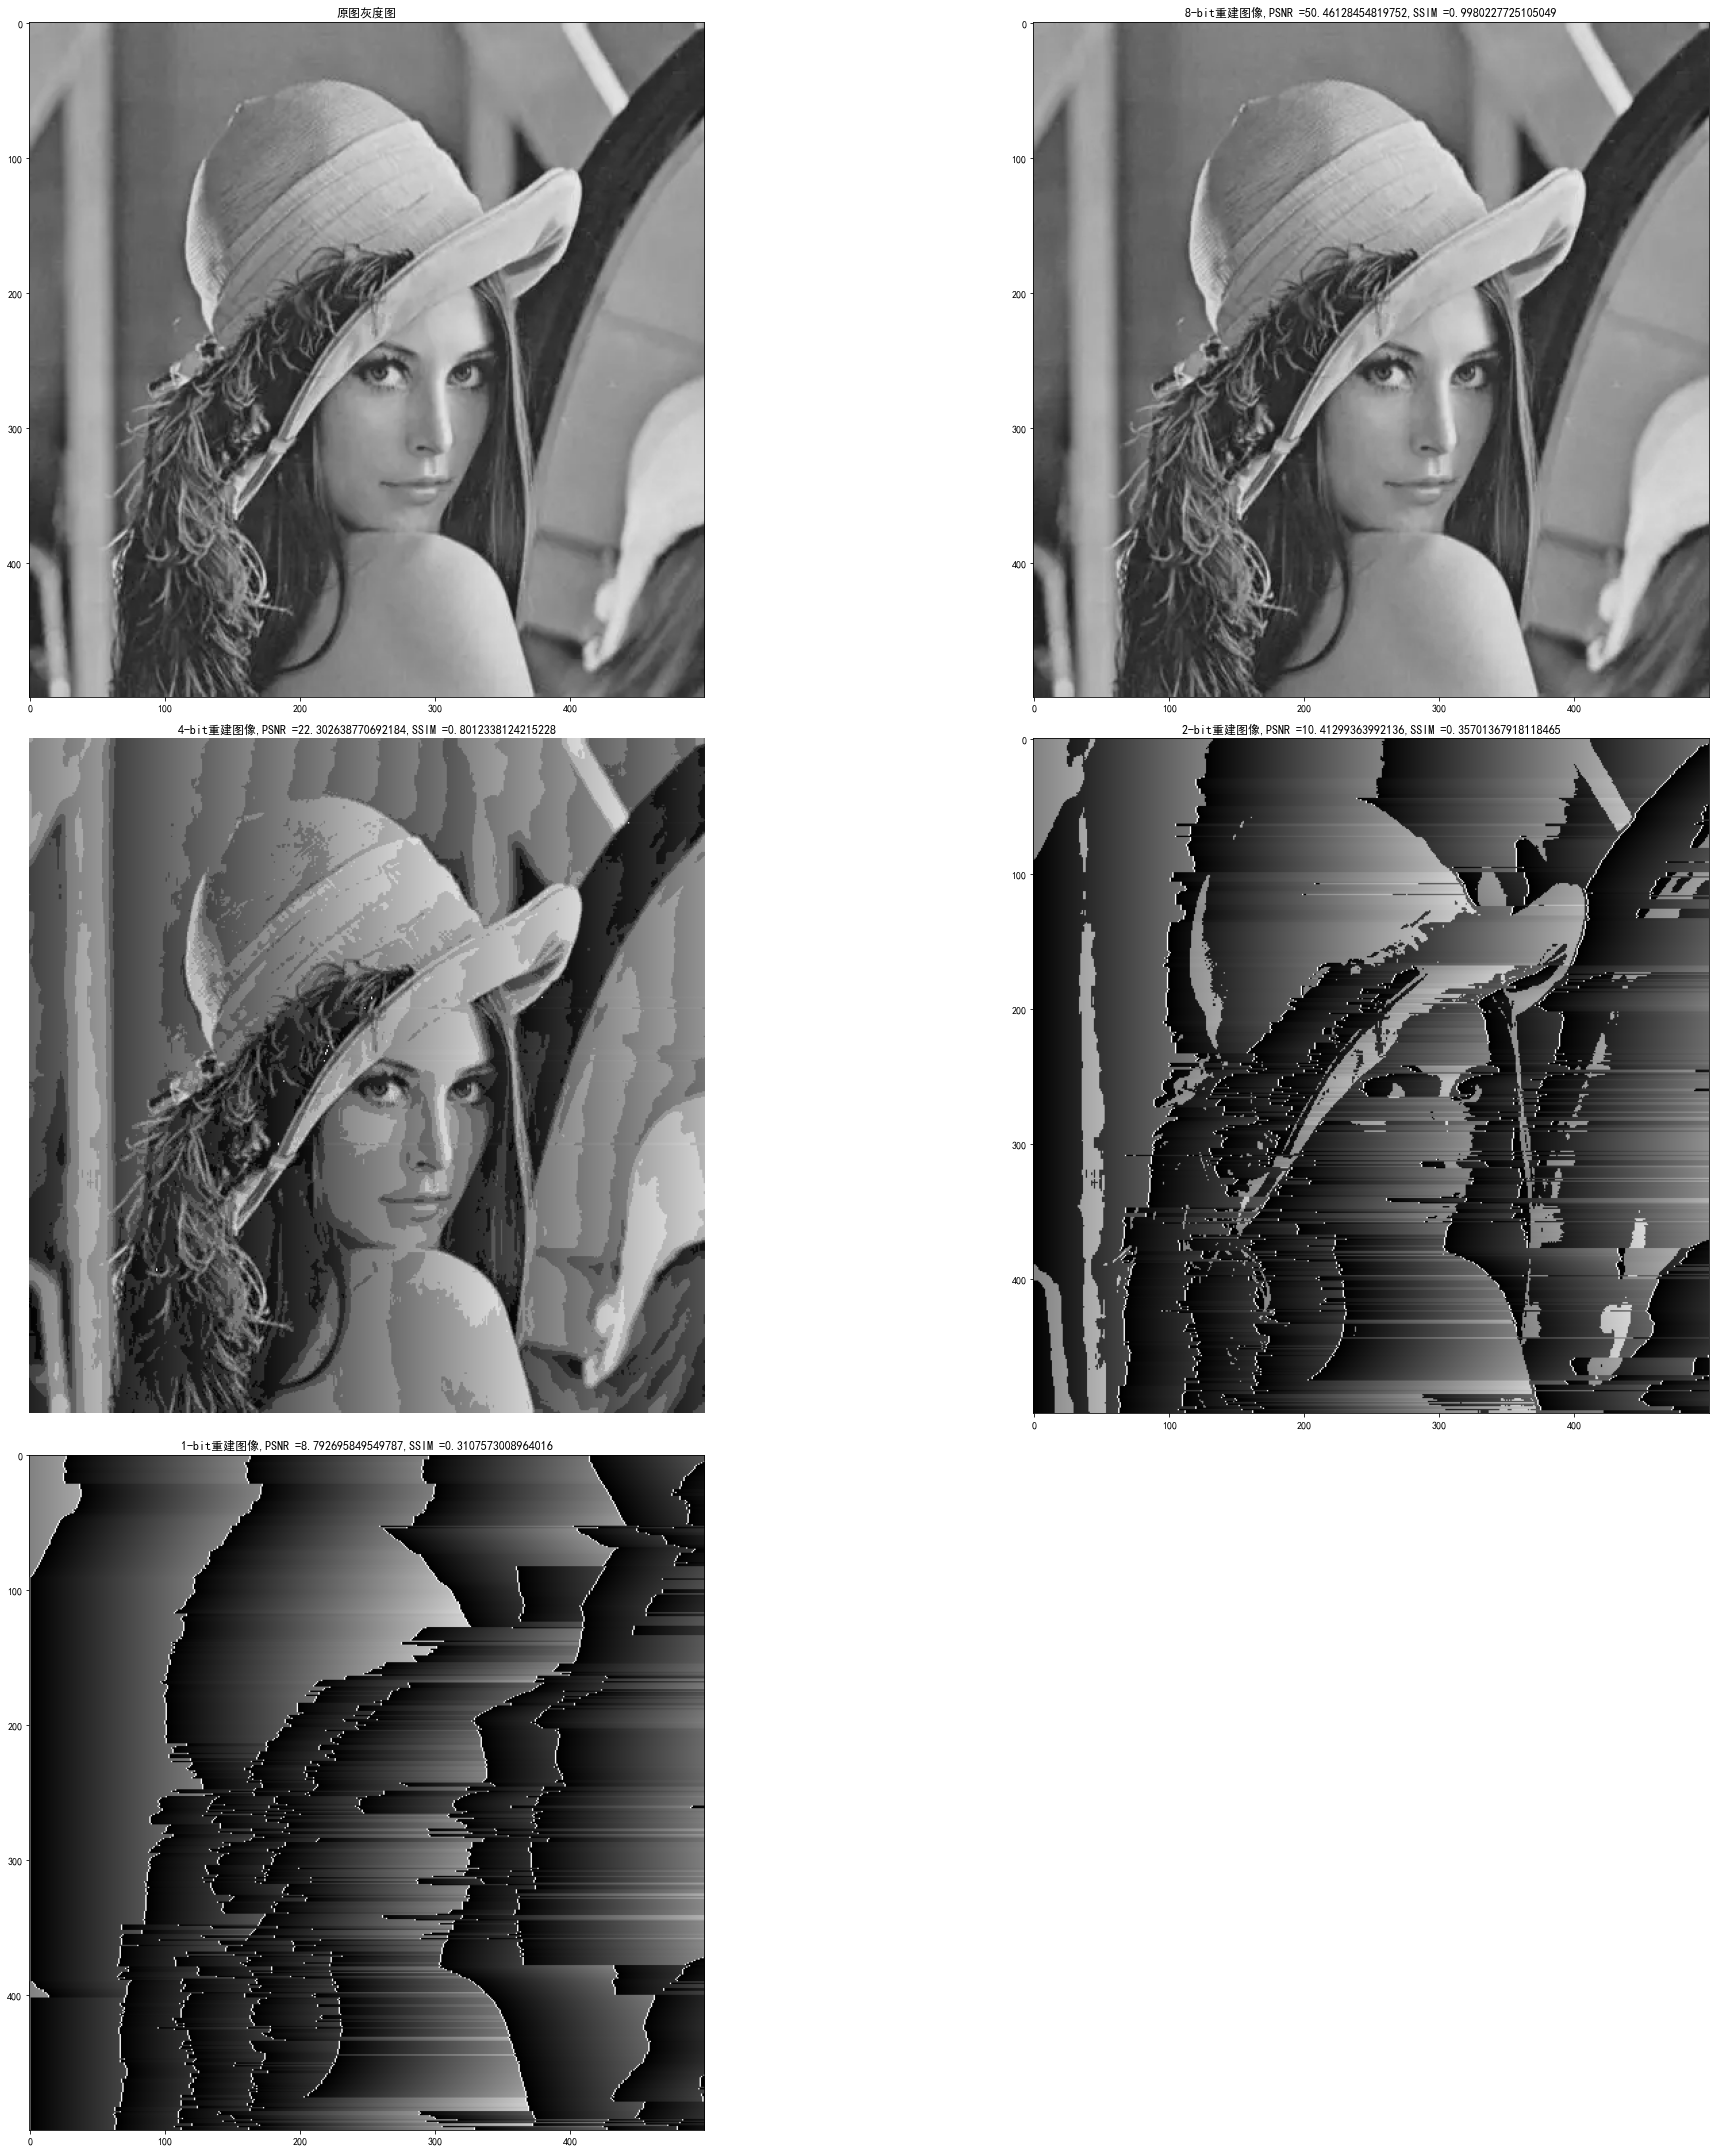

In [2]:
'''
DPCM 差分脉冲编码调制（Differential Pulse Code Modulation）:通过对图像进行预测编码并缩减图片预测误差的动态范围来实现图像的压缩。
对灰度图像进行编码和解码，要求只对亮度信号 Y 通道进行编码压缩，
将图片的第一列像素值作为原始参考值进行预测，通过与左侧的像素值取差计算预测误差，然后进行量化编码。
'''
import cv2
import numpy as np
import matplotlib.pyplot as plt
import io
import math
from scipy.signal import convolve2d

# 定义DPCM算法
def DPCM_encodeing(y,img_re,yprebuff,factor):
    radio=512/(1<<factor)  #量化因子  8是左向预测8bit量化
    for i in range(h):
        for j in range(w):
            # 左向预测8bit量化
            if j == 0:
                # 每行第一个像素做一定变换预测
                ypre = y[j + i * w]-128  # 计算预测误差
                yprebuff[j + i * w] = (ypre+255)/radio  # 量化预测误差
                img_re[j + i * w] = (yprebuff[j + i * w]-255/radio)*radio+128  # 重建像素,j解码
                if img_re[j + i * w]>255:
                    img_re[j + i * w] = 255# 防止重建像素超过255
                yprebuff[j + i * w] = yprebuff[j + i * w]*radio/2

            else:
                ypre = y[j + i * w] - img_re[j + i * w - 1]
                yprebuff[j + i * w] = (ypre+255) /radio
                img_re[j + i * w] = (yprebuff[j + i * w]-255/radio)*radio+img_re[j + i * w - 1]  # 反量化
                yprebuff[j + i * w] = yprebuff[j + i * w] * radio / 2  # 预测器
                if img_re[j + i * w]>255:
                    img_re[j + i * w] = 255
    img_re = img_re.astype(np.uint8) # 用来存储重建图像
    yprebuff = yprebuff.astype(np.uint8)  # 预测误差
    
    return y,img_re,yprebuff  

 # target:目标图像  ref:参考图像 
def PSNR(target, ref):
    target = np.array(target, dtype=np.float32)
    ref = np.array(ref, dtype=np.float32)
 
    diff = ref - target
    diff = diff.flatten('C')
 
    rmse = math.sqrt( np.mean(diff ** 2.) )
    psnr = 20 * math.log10(np.max(target) / rmse)
 
    return psnr
 
def SSIM(target, ref, K1=0.01, K2=0.03, gaussian_kernel_sigma = 1.5, gaussian_kernel_width = 11, L=255):
    # 高斯核，方差为1.5，滑窗为11*11
    gaussian_kernel = np.zeros((gaussian_kernel_width,gaussian_kernel_width))
    for i in range(gaussian_kernel_width):
        for j in range(gaussian_kernel_width):
            gaussian_kernel[i,j] = (1 / (2 * math.pi * (gaussian_kernel_sigma ** 2))) * math.exp(-(((i-5) ** 2)+((j - 5) ** 2)) / (2 * (gaussian_kernel_sigma ** 2)))
 
    target = np.array(target, dtype=np.float32)
    ref = np.array(ref, dtype=np.float32)

    target_window = convolve2d(target, np.rot90(gaussian_kernel, 2), mode='valid')
    ref_window = convolve2d(ref, np.rot90(gaussian_kernel, 2), mode='valid')
 
    mu1_sq = target_window * target_window
    mu2_sq = ref_window * ref_window
    mu1_mu2 = target_window * ref_window
 
    sigma1_sq = convolve2d(target * target, np.rot90(gaussian_kernel, 2), mode='valid') - mu1_sq
    sigma2_sq = convolve2d(ref * ref, np.rot90(gaussian_kernel, 2), mode='valid') - mu2_sq
    sigma12 = convolve2d(target * ref, np.rot90(gaussian_kernel, 2), mode='valid') - mu1_mu2
 
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    ssim_array = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    ssim = np.mean(np.mean(ssim_array))
 
    return ssim

# 执行代码部分
# 读取图片，并转换为 y,v, u 分量。
img = cv2.imread('./lena.jpg')
h, w = img.shape[:2]  # 长 宽                    

yvu = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)# 将 BGR 转换为 YCrCb
y, v, u = cv2.split(yvu)  # 区分通道 y u v


u = cv2.resize(u, (u.shape[1] // 2, u.shape[0] // 2))  # 注意不要有小数
v = cv2.resize(v, (v.shape[1] // 2, v.shape[0] // 2))

f = io.BytesIO()  # 以数据流形式输入
f.write(y.tobytes())
f.write(u.tobytes())
f.write(v.tobytes())
f.seek(0)

img_np = np.frombuffer(f.read(), np.uint8)

img_yuv_len = img_np.size
img_y_len = h * w

y = img_np[:img_y_len]
u = img_np[img_y_len:(img_yuv_len - img_y_len) // 2 + img_y_len]
v = img_np[(img_yuv_len - img_y_len) // 2 + img_y_len:]

# DPCM量化编码，采用边编码，边解码的形式
img_re = np.zeros(img_y_len, np.uint16)  # 用来存储重建图像
yprebuff = np.zeros(img_y_len, np.uint16)  # 预测


# 使用8-bit量化器重建图片
y8,img_re8,yprebuff8=DPCM_encodeing(y,img_re,yprebuff,8)
y8 = y8.reshape((h,w))  # 转换向量形状回原来的y分量
yprebuff8 = yprebuff8.reshape((h,w))  # 预测的y分量
img_re8 = img_re8.reshape((h,w))  # 重建的y分量
PSNR8 = PSNR(y8,img_re8)
SSIM8 = SSIM(y8,img_re8)


# 使用4-bit量化器重建图片
y4,img_re4,yprebuff4=DPCM_encodeing(y,img_re,yprebuff,4)
y4 = y4.reshape((h,w))  
yprebuff4 = yprebuff4.reshape((h,w)) 
img_re4 = img_re4.reshape((h,w))  
PSNR4 = PSNR(y4,img_re4)
SSIM4 = SSIM(y4,img_re4)

# 使用2-bit量化器重建图片
y2,img_re2,yprebuff2=DPCM_encodeing(y,img_re,yprebuff,2)
y2 = y2.reshape((h,w))  
yprebuff2 = yprebuff2.reshape((h,w))  
img_re2 = img_re2.reshape((h,w))  
PSNR2 = PSNR(y2,img_re2)
SSIM2 = SSIM(y2,img_re2)

#使用1-bit量化器重建图片
y1,img_re1,yprebuff1=DPCM_encodeing(y,img_re,yprebuff,1)
y1 = y1.reshape((h,w))  
yprebuff1 = yprebuff1.reshape((h,w))  
img_re1 = img_re1.reshape((h,w)) 
PSNR1 = PSNR(y1,img_re1)
SSIM1 = SSIM(y1,img_re1)

# 将原来的y,u,v分量转换回图片
bgr = cv2.cvtColor(yvu, cv2.COLOR_YCrCb2BGR)

# 防止中文报错
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

# 展示图像结果
plt.figure(figsize=(30, 30))
plt.subplot(321), plt.imshow(cv2.cvtColor(y8, cv2.COLOR_BGR2RGB),cmap='gray')  
plt.title('原图灰度图')
plt.subplot(322), plt.imshow(cv2.cvtColor(img_re8, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title('8-bit重建图像,PSNR ='+str(PSNR8)+',SSIM ='+str(SSIM8))
plt.subplot(323), plt.imshow(cv2.cvtColor(img_re4, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title('4-bit重建图像,PSNR ='+str(PSNR4)+',SSIM ='+str(SSIM4)), plt.axis('off')
plt.subplot(324), plt.imshow(cv2.cvtColor(img_re2, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title('2-bit重建图像,PSNR ='+str(PSNR2)+',SSIM ='+str(SSIM2))
plt.subplot(325), plt.imshow(cv2.cvtColor(img_re1, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title('1-bit重建图像,PSNR ='+str(PSNR1)+',SSIM ='+str(SSIM1))

plt.tight_layout()  # 排版
plt.show()